In [1]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import mean_squared_error as MSE,mean_absolute_error
from tabulate import tabulate
from sklearn.model_selection import train_test_split

import csv

Using TensorFlow backend.


In [56]:
names = ['user_id','age','gender','occupation','zip_code']
u_user = pd.read_csv('ml-100k/u.user', sep='|', names=names)
u_user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [57]:
u_user[u_user.isnull().T.any()]

,user_id,age,gender,occupation,zip_code


In [58]:
name=['UserID','MovieID','Rating','Timestamp']
ratings_dfs=pd.read_csv('ml-100k/u.data',sep='\t',names=name)
ratings_dfs.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [59]:
user_rating_dfs = ratings_dfs.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_dfs.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
user_rating_dfs[user_rating_dfs.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserID,,,,,,,,,,,,,,,,,,,,,
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
len(user_rating_dfs)

943

In [61]:
norm_user_rating_dfs = user_rating_dfs.fillna(0) / 5.0
trXs = norm_user_rating_dfs.values
trXs[0:5]

array([[1. , 0.6, 0.8, ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0.6, 0. , ..., 0. , 0. , 0. ]])

In [62]:
trXs[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0.8, 0. , 0.8, ..., 0. , 0. , 0. ])

In [90]:
errors_DBNs=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.125  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBNs.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [91]:
RBM_hidden_sizes = [800, 400  ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trXs

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   1682 -> 800
RBM:  1   800 -> 400


In [92]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Epoch: 0 reconstruction error: 0.092529
Epoch: 1 reconstruction error: 0.082419
Epoch: 2 reconstruction error: 0.076833
Epoch: 3 reconstruction error: 0.072492
Epoch: 4 reconstruction error: 0.068665
Epoch: 5 reconstruction error: 0.067015
Epoch: 6 reconstruction error: 0.064985
Epoch: 7 reconstruction error: 0.064457
Epoch: 8 reconstruction error: 0.062854
Epoch: 9 reconstruction error: 0.062776
Epoch: 10 reconstruction error: 0.062946
Epoch: 11 reconstruction error: 0.062265
Epoch: 12 reconstruction error: 0.061407
Epoch: 13 reconstruction error: 0.060808
Epoch: 14 reconstruction error: 0.060070
New RBM:
Epoch: 0 reconstruction error: 0.002152
Epoch: 1 reconstruction error: 0.002055
Epoch: 2 reconstruction error: 0.002033
Epoch: 3 reconstruction error: 0.001928
Epoch: 4 reconstruction error: 0.001861
Epoch: 5 reconstruction error: 0.001787
Epoch: 6 reconstruction error: 0.001790
Epoch: 7 reconstruction error: 0.001662
Epoch: 8 reconstruction error: 0.001623
Epoch: 9 reconstr

In [13]:
#Loading in the movies dataset
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
# Loading the ratings dataset
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [15]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [17]:
len(movies_df)

3883

In [18]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
user_rating_df[user_rating_df.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
215,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
len(user_rating_df)

6040

In [20]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
trX[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0., 0., 1., ..., 0., 0., 0.])

In [95]:
errors_DBN=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.075  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [96]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [97]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Epoch: 0 reconstruction error: 0.056201
Epoch: 1 reconstruction error: 0.053090
Epoch: 2 reconstruction error: 0.050228
Epoch: 3 reconstruction error: 0.047611
Epoch: 4 reconstruction error: 0.045731
Epoch: 5 reconstruction error: 0.044443
Epoch: 6 reconstruction error: 0.043252
Epoch: 7 reconstruction error: 0.042291
Epoch: 8 reconstruction error: 0.041376
Epoch: 9 reconstruction error: 0.040693
Epoch: 10 reconstruction error: 0.040161
Epoch: 11 reconstruction error: 0.039493
Epoch: 12 reconstruction error: 0.039257
Epoch: 13 reconstruction error: 0.038677
Epoch: 14 reconstruction error: 0.038460
New RBM:
Epoch: 0 reconstruction error: 0.001172
Epoch: 1 reconstruction error: 0.000998
Epoch: 2 reconstruction error: 0.000901
Epoch: 3 reconstruction error: 0.000851
Epoch: 4 reconstruction error: 0.000789
Epoch: 5 reconstruction error: 0.000765
Epoch: 6 reconstruction error: 0.000737
Epoch: 7 reconstruction error: 0.000729
Epoch: 8 reconstruction error: 0.000731
Epoch: 9 reconstr

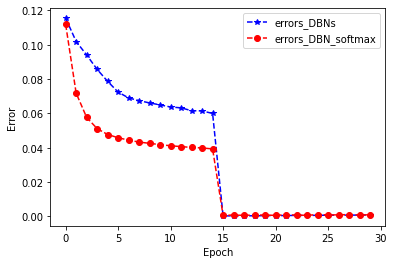

In [25]:
plt.plot(errors_DBNs,'--*b',label='errors_DBNs')
plt.plot(errors_DBN,'--or',label='errors_DBN_softmax')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [26]:
name=['UserID','MovieID','Rating','Timestamp']
ratings_dfx=pd.read_csv('ml-25m/ratings.csv',names=name,skiprows=1,header=None)
ratings_dfx.head()

,UserID,MovieID,Rating,Timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [27]:
# 3

In [28]:
ratings_dfx=ratings_dfx.iloc[:1500000,:3]
len(ratings_dfx)

1500000

In [29]:
# ratings_dfx=np.float16(ratings_dfx)


user_rating_dfx = ratings_dfx.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_dfx.head()
#写入 Q.csv 文件中
# with open ("ml-25m/user_rating.csv","w",newline="") as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(user_rating_dfx)




MovieID,1,2,3,4,5,6,7,8,9,10,...,208112,208507,208513,208515,208715,208737,208787,208793,208939,209163
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
user_rating_dfx=user_rating_dfx.iloc[:10000,:]
len(user_rating_dfx)

10000

In [31]:
# user_rating_dfx=pd.read_csv('ml-25m/user_rating.csv')

user_rating_dfx[user_rating_dfx.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,208112,208507,208513,208515,208715,208737,208787,208793,208939,209163
UserID,,,,,,,,,,,,,,,,,,,,,
215,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
norm_user_rating_dfx = user_rating_dfx.fillna(0) / 5.0
trXx = norm_user_rating_dfx.values
trXx[0:5]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.7, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.6, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [33]:
trXx[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0.8, 0.6, 0. , ..., 0. , 0. , 0. ])

In [34]:
errors_DBNx=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 1  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBNx.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [35]:
RBM_hidden_sizes = [10000, 5000] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trXx

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   24331 -> 10000
RBM:  1   10000 -> 5000


In [36]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Epoch: 0 reconstruction error: 0.027225
Epoch: 1 reconstruction error: 0.016847
Epoch: 2 reconstruction error: 0.013411
Epoch: 3 reconstruction error: 0.011701
Epoch: 4 reconstruction error: 0.010672
Epoch: 5 reconstruction error: 0.010021
Epoch: 6 reconstruction error: 0.009536
Epoch: 7 reconstruction error: 0.009188
Epoch: 8 reconstruction error: 0.008920
Epoch: 9 reconstruction error: 0.008709
Epoch: 10 reconstruction error: 0.008536
Epoch: 11 reconstruction error: 0.008418
Epoch: 12 reconstruction error: 0.008274
Epoch: 13 reconstruction error: 0.008163
Epoch: 14 reconstruction error: 0.007889
New RBM:
Epoch: 0 reconstruction error: 0.000047
Epoch: 1 reconstruction error: 0.000044
Epoch: 2 reconstruction error: 0.000035
Epoch: 3 reconstruction error: 0.000025
Epoch: 4 reconstruction error: 0.000030
Epoch: 5 reconstruction error: 0.000032
Epoch: 6 reconstruction error: 0.000034
Epoch: 7 reconstruction error: 0.000035
Epoch: 8 reconstruction error: 0.000036
Epoch: 9 reconstr

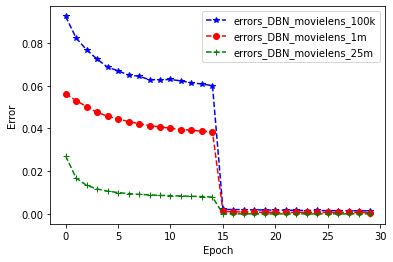

In [98]:
# from matplotlib.pyplot import MultipleLocator

plt.plot(errors_DBNs,'--*b',label='errors_DBN_movielens_100k')
plt.plot(errors_DBN,'--or',label='errors_DBN_movielens_1m')
plt.plot(errors_DBNx,'--+g',label='errors_DBN_movielens_25m')
plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')


plt.show()

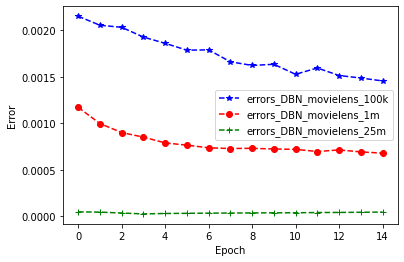

In [99]:
errors_DBN_1=errors_DBN[15:30]
errors_DBNs_1=errors_DBNs[15:30]
errors_DBNx_1=errors_DBNx[15:30]



plt.plot(errors_DBNs_1,'--*b',label='errors_DBN_movielens_100k')
plt.plot(errors_DBN_1,'--or',label='errors_DBN_movielens_1m')
plt.plot(errors_DBNx_1,'--+g',label='errors_DBN_movielens_25m')
plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [100]:
ratings_dfd=pd.read_csv('doubanmovies/ratings.csv')
ratings_dfd.head()

,RATING_ID,USER_MD5,MOVIE_ID,RATING,RATING_TIME
0,1359352573,0ab7e3efacd56983f16503572d2b9915,5113101,2,2018-09-05 19:42:07
1,1598245094,84dfd3f91dd85ea105bc74a4f0d7a067,5113101,1,2019-07-09 14:52:07
2,311937819,c9a47fd59b55967ceac07cac6d5f270c,3718526,3,2010-11-05 22:15:44
3,457663846,18cbf971bdf17336056674bb8fad7ea2,3718526,4,2011-11-14 22:31:02
4,313277849,47e69de0d68e6a4db159bc29301caece,3718526,4,2010-11-09 12:41:11


In [101]:
ratings_dfd.columns=['RatingID','UserID','MovieID','Rating','Rating_time']
ratings_dfd.head()

,RatingID,UserID,MovieID,Rating,Rating_time
0,1359352573,0ab7e3efacd56983f16503572d2b9915,5113101,2,2018-09-05 19:42:07
1,1598245094,84dfd3f91dd85ea105bc74a4f0d7a067,5113101,1,2019-07-09 14:52:07
2,311937819,c9a47fd59b55967ceac07cac6d5f270c,3718526,3,2010-11-05 22:15:44
3,457663846,18cbf971bdf17336056674bb8fad7ea2,3718526,4,2011-11-14 22:31:02
4,313277849,47e69de0d68e6a4db159bc29301caece,3718526,4,2010-11-09 12:41:11


In [102]:
len(ratings_dfd)

4169420

In [103]:
ratings_dfd=ratings_dfd.iloc[:60000,:]

In [104]:
len(ratings_dfd)

60000

In [105]:
user_rating_dfd = ratings_dfd.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_dfd.head()

MovieID,1292568,1292627,1292629,1292688,1292878,1292899,1292903,1292998,1293008,1293066,...,30419844,30441128,30446698,30462403,30465748,30468266,30482802,33405208,33414510,33456096
UserID,,,,,,,,,,,,,,,,,,,,,
0001773246f25b3c7ab97ce05af9dafa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002296a304732a414f3cffb07bc7c3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00034e6ca83cce11c894376bda67bdd9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00045aa2be0e6e6cd020444f7b0d7feb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0007d6911bc813d01bfec69348fe1316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
len(user_rating_dfd)

35226

In [107]:
user_rating_dfd=user_rating_dfd.iloc[:10000,:]
len(user_rating_dfd)

10000

In [108]:
user_rating_dfd[user_rating_dfd.index=='00034e6ca83cce11c894376bda67bdd9']

MovieID,1292568,1292627,1292629,1292688,1292878,1292899,1292903,1292998,1293008,1293066,...,30419844,30441128,30446698,30462403,30465748,30468266,30482802,33405208,33414510,33456096
UserID,,,,,,,,,,,,,,,,,,,,,
00034e6ca83cce11c894376bda67bdd9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
norm_user_rating_dfd = user_rating_dfd.fillna(0) / 5.0
trXd = norm_user_rating_dfd.values
trXd[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [110]:
trXd[215]

array([0., 0., 0., ..., 0., 0., 0.])

In [111]:
errors_DBNd=[]

class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.075  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBNd.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [112]:
RBM_hidden_sizes = [500, 250  ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trXd

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   1111 -> 500
RBM:  1   500 -> 250


In [113]:
#For each RBM in our list

for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Epoch: 0 reconstruction error: 0.003079
Epoch: 1 reconstruction error: 0.002395
Epoch: 2 reconstruction error: 0.002176
Epoch: 3 reconstruction error: 0.002055
Epoch: 4 reconstruction error: 0.001994
Epoch: 5 reconstruction error: 0.001973
Epoch: 6 reconstruction error: 0.001932
Epoch: 7 reconstruction error: 0.001886
Epoch: 8 reconstruction error: 0.001909
Epoch: 9 reconstruction error: 0.001886
Epoch: 10 reconstruction error: 0.001872
Epoch: 11 reconstruction error: 0.001866
Epoch: 12 reconstruction error: 0.001866
Epoch: 13 reconstruction error: 0.001852
Epoch: 14 reconstruction error: 0.001859
New RBM:
Epoch: 0 reconstruction error: 0.004969
Epoch: 1 reconstruction error: 0.003011
Epoch: 2 reconstruction error: 0.002467
Epoch: 3 reconstruction error: 0.002235
Epoch: 4 reconstruction error: 0.002141
Epoch: 5 reconstruction error: 0.002114
Epoch: 6 reconstruction error: 0.002064
Epoch: 7 reconstruction error: 0.002039
Epoch: 8 reconstruction error: 0.002042
Epoch: 9 reconstr

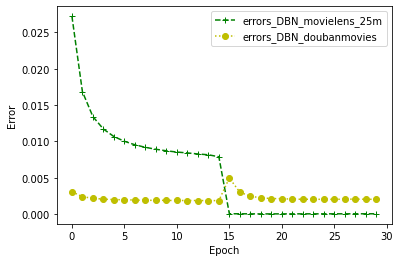

In [114]:
# plt.plot(errors_DBNs,'--*b',label='errors_DBN_movielens_100k')
# plt.plot(errors_DBN,'--or',label='errors_DBN_movielens_1m')
plt.plot(errors_DBNx,'--+g',label='errors_DBN_movielens_25m')
plt.plot(errors_DBNd,'o:y',label='errors_DBN_doubanmovies')

plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

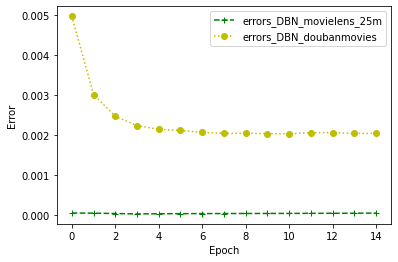

In [115]:
# errors_DBN=errors_DBN[15:30]
# errors_DBNs=errors_DBNs[15:30]
errors_DBNx1=errors_DBNx[15:30]
errors_DBNd1=errors_DBNd[15:30]




# plt.plot(errors_DBNs,'--*b',label='errors_DBN_movielens_100k')
# plt.plot(errors_DBN,'--or',label='errors_DBN_movielens_1m')
plt.plot(errors_DBNx1,'--+g',label='errors_DBN_movielens_25m')
plt.plot(errors_DBNd1,'o:y',label='errors_DBN_doubanmovies')
plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()